#### In this notebook I will create my first base model. This model will be a minial viable product end to end. The workflow for this notebook will be as follows 

* Model Selection
    * Logistic Regression 
    * Hyperparamter tunning (GS)
    
* Model Build and train 
* Serialize for deployment

In [3]:
import pandas as pd 
import matplotlib 
from matplotlib import  pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn import compose as cmp
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
from sklearn import linear_model as lin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics as met
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Data_Set_EDA_1.csv')

In [5]:
df.drop(columns ='Unnamed: 0', inplace = True)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


### Model

In [6]:
# Data split
from sklearn import model_selection as mod
X = df.drop("Churn", axis = 1)
y = df.Churn

In [7]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2, stratify = y)

In [8]:
#Numerical 
numCols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [9]:
# Pipeline

from sklearn import compose as cmp
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
from sklearn import linear_model as lin
from sklearn.preprocessing import MinMaxScaler

# PreProcessing
preprocessor = cmp.ColumnTransformer(transformers=[
    ('num', pre. MinMaxScaler(), numCols),],
    remainder = 'passthrough')

In [10]:
# Pipe
pipe = pip.Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', lin.LogisticRegression(max_iter=3000))])


params = [
          {'classifier__C'      : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
           'classifier__penalty': ['l1'], 
           'classifier__solver' : ['liblinear', 'saga'],
           'classifier__class_weight' : [{0:0.25,1:1}, {0:0.5,1:1}, {0:0.75,1:1}, 'balanced']},
          
          {'classifier__C'      : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
           'classifier__penalty': ['l2'], 
           'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
           'classifier__class_weight' : [{0:0.25,1:1}, {0:0.5,1:1}, {0:0.75,1:1}, 'balanced']}
         ]


In [11]:
# Grid Search 
cv = mod.StratifiedKFold(n_splits = 5, shuffle = True)
grid1 = mod.GridSearchCV(pipe, param_grid = params, cv = cv, verbose = 0, n_jobs = -1, scoring = "accuracy")

grid1.fit(x_train, y_train);
grid1.best_estimator_[1]



LogisticRegression(C=1, class_weight={0: 0.75, 1: 1}, max_iter=3000,
                   penalty='l1', solver='saga')

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1033
           1       0.63      0.67      0.65       374

    accuracy                           0.81      1407
   macro avg       0.75      0.76      0.76      1407
weighted avg       0.81      0.81      0.81      1407



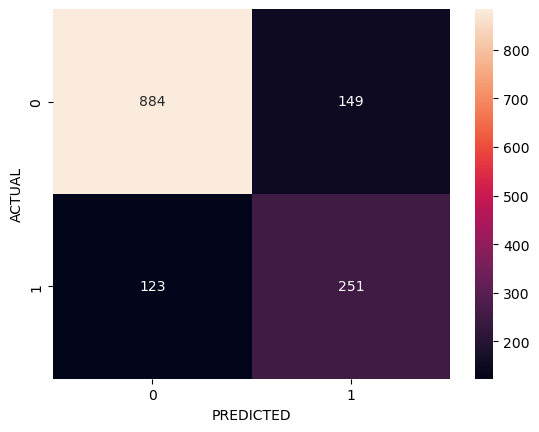

In [43]:
from sklearn import metrics as met
cm = met.confusion_matrix(y_test, grid1.best_estimator_.predict(x_test))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels = ["0", "1"] , 
                yticklabels = ["0", "1"] )
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
     
print(met.classification_report(y_test, grid1.best_estimator_.predict(x_test)))

The accuracy is at 80% which is okay, however recall is at .63% for the churn class. The reason is probably because the data is not balanced. There are a few approaches to get better recall. I'll try a few. 

* Change the scoring in my pipline to a account for the inbalance 
* Oversampling 
* Undersampling 

## Approach 1 
### Changing the scoring function in my pipline and adding a weight bias to the FN (Customers identified as staying but actually churned) since it causes the most damage.

First lets break down the confusion matrix. From a business standpoint. 

**TP:** Customers identified as churning and actually churned. 

Those customers will need focus from the company and test ways to retain, run the analysis again and see if their approach worked, for customers with similar features. 

**TN:** Customers identified as staying and actually stayed. No action needed for them.

**FP:** Customers identified as churning but actually stayed. Again they would be in the plan of giving discounts, but this time for nothing.

**FN:** Customers identified as staying but actually churned. No action are taken on them yet they leave. Complete loss of income from that customer. The most costly one.

**If we give hypotetical costs for each of them, while indicating the high cost of FN:** this could help eleviate the imbalance. 

TP: 10 
TN: 0 
FP: 10 
FN: 60 


In [14]:
def C_Score(y_actual, y_pred):
    cm = met.confusion_matrix(y_actual, y_pred).ravel().tolist()
    cost = 60*cm[2]+ 0*cm[0] + 10*cm[1] + 10*cm[3]
    return cost

#sklearn make_scorer for the churnScorer
churn_score = met.make_scorer(C_Score, greater_is_better = False)

In [15]:
# Grid Search 
cv = mod.StratifiedKFold(n_splits = 5, shuffle = True)
grid2 = mod.GridSearchCV(pipe, param_grid = params, cv = cv, verbose = 0, n_jobs = -1, scoring = churn_score)

grid2.fit(x_train, y_train);
grid2.best_estimator_[1]



LogisticRegression(C=10, class_weight={0: 0.25, 1: 1}, max_iter=3000,
                   penalty='l1', solver='liblinear')

              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1033
           1       0.47      0.86      0.61       374

    accuracy                           0.70      1407
   macro avg       0.70      0.75      0.68      1407
weighted avg       0.80      0.70      0.72      1407



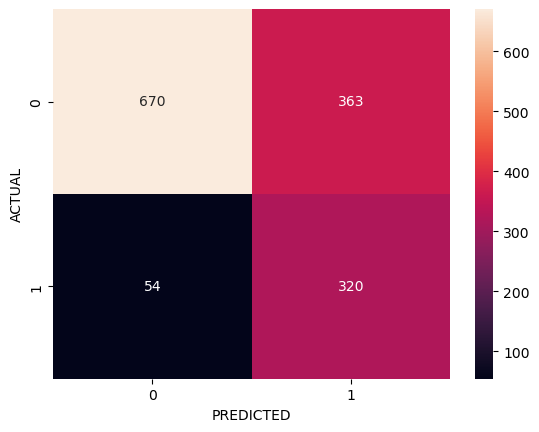

In [42]:
cm = met.confusion_matrix(y_test, grid2.best_estimator_.predict(x_test))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels = ["0", "1"] , 
                yticklabels = ["0", "1"] )
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
     
print(met.classification_report(y_test, grid2.best_estimator_.predict(x_test)))

### The custom scoring function improved the recall for the churned (minority) class from 53% to 87% and F1 score improved slightly, however the accuracy dropped a lot.

* A balancing technique known as SMOTE will be used in model 1 to fix this imbalance and improve ,my models predictive power. 

## Deployment 

In [19]:
# Serialization 
import pickle
filename = 'model.sav'
pickle.dump(grid1.best_estimator_, open(filename, 'wb'))

In [20]:
#Load model 
load_model = pickle.load(open(filename, 'rb'))

In [21]:
model_score_r1 = load_model.score(x_test, y_test)
model_score_r1

0.806680881307747